In [6]:
# -----------------------------
# 0️⃣ Setup Project Root & Imports
# -----------------------------
import sys
import os

# --- Project root ---
# Adjust based on notebook location: ML/notebooks/modelling/
project_root = os.path.abspath(os.path.join(os.getcwd(), "../../"))  # ML/
print("Project root:", project_root)

# --- Add src folder to sys.path ---
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.insert(0, src_path)
print("SRC path added to sys.path:", src_path)

# --- CSV file path ---
data_path = os.path.join(project_root, "data/processed/insurance_data_cleaned.csv")
print("Data file path:", data_path)

# -----------------------------
# 1️⃣ Imports
# -----------------------------
# Data handling
import pandas as pd
import numpy as np

# Modeling utilities
from modelling.data_preparation import (
    load_data,
    filter_claims,
    handle_missing_values,
    get_categorical_columns,
    encode_categoricals,
    feature_engineering,
    train_test_split_data
)
from modelling.train_models import train_all_models
from modelling.evaluate_models import (
    evaluate_all_models,
    get_feature_importance,
    shap_summary_plot,
    save_shap_summary_plot
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# Display settings
pd.set_option('display.max_columns', None)


Project root: c:\Users\derej\Desktop\Kifya\ML
SRC path added to sys.path: c:\Users\derej\Desktop\Kifya\ML\src
Data file path: c:\Users\derej\Desktop\Kifya\ML\data/processed/insurance_data_cleaned.csv


In [20]:
df = load_data(data_path)
df = filter_claims(df)
df = handle_missing_values(df)
df = feature_engineering(df)

categorical_cols = get_categorical_columns(df)
df_encoded = encode_categoricals(df, categorical_cols)

X_train, X_test, y_train, y_test = train_test_split_data(df_encoded, target='TotalClaims')


Dropping fully empty columns: ['CrossBorder', 'NumberOfVehiclesInFleet']


In [21]:
# -----------------------------
# Step 1: Training models
# -----------------------------
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Initialize only the requested models
models = {
    "LinearRegression": LinearRegression(),
    "DecisionTree": DecisionTreeRegressor(random_state=42, max_depth=10),
    "RandomForest": RandomForestRegressor(random_state=42, n_estimators=100, max_depth=10),
    "XGBoost": xgb.XGBRegressor(
        random_state=42, 
        n_estimators=100, 
        max_depth=5, 
        objective='reg:squarederror'
    )
}

# Train each model
trained_models = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    trained_models[name] = model
    print(f"{name} trained successfully!")


LinearRegression trained successfully!
DecisionTree trained successfully!
RandomForest trained successfully!
XGBoost trained successfully!


In [22]:
# -----------------------------
# Step 2: Evaluate trained models
# -----------------------------
from modelling.evaluate_models import evaluate_all_models

# Evaluate all models
evaluation_results = evaluate_all_models(trained_models, X_test, y_test)

# Convert results to a DataFrame for easier visualization
eval_df = pd.DataFrame(evaluation_results).T  # transpose to have models as rows
eval_df = eval_df.reset_index().rename(columns={'index': 'Model'})
eval_df


Model,Model,LinearRegression,DecisionTree,RandomForest,XGBoost
0,RMSE,30551.547541,11705.672181,8056.371098,10290.922944
1,R2,0.331361,0.901844,0.953505,0.924136


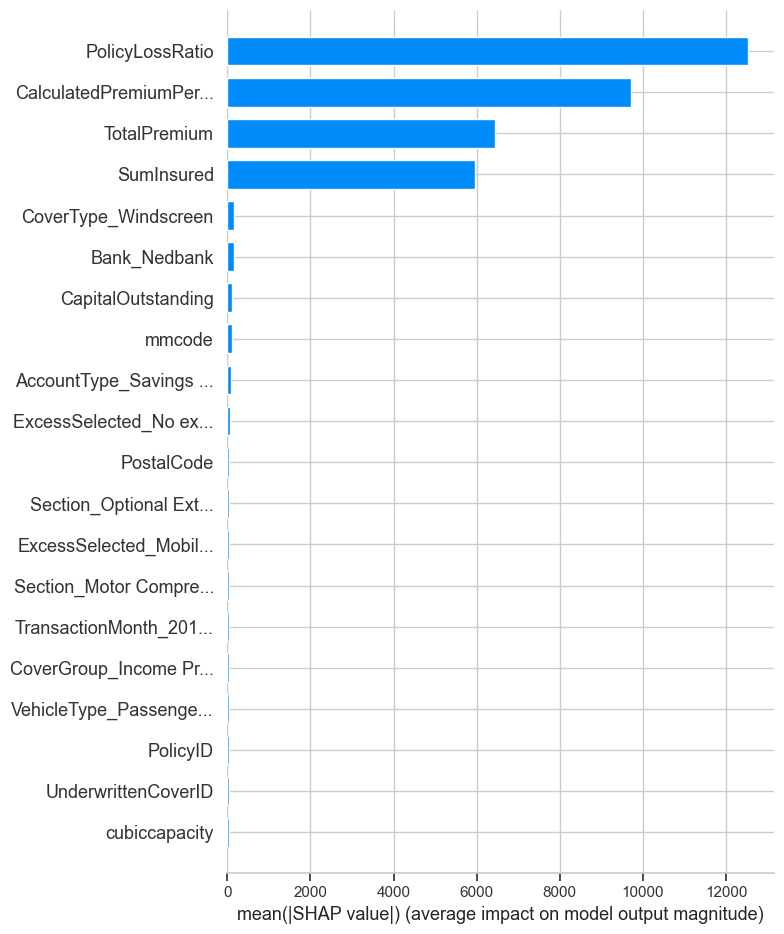

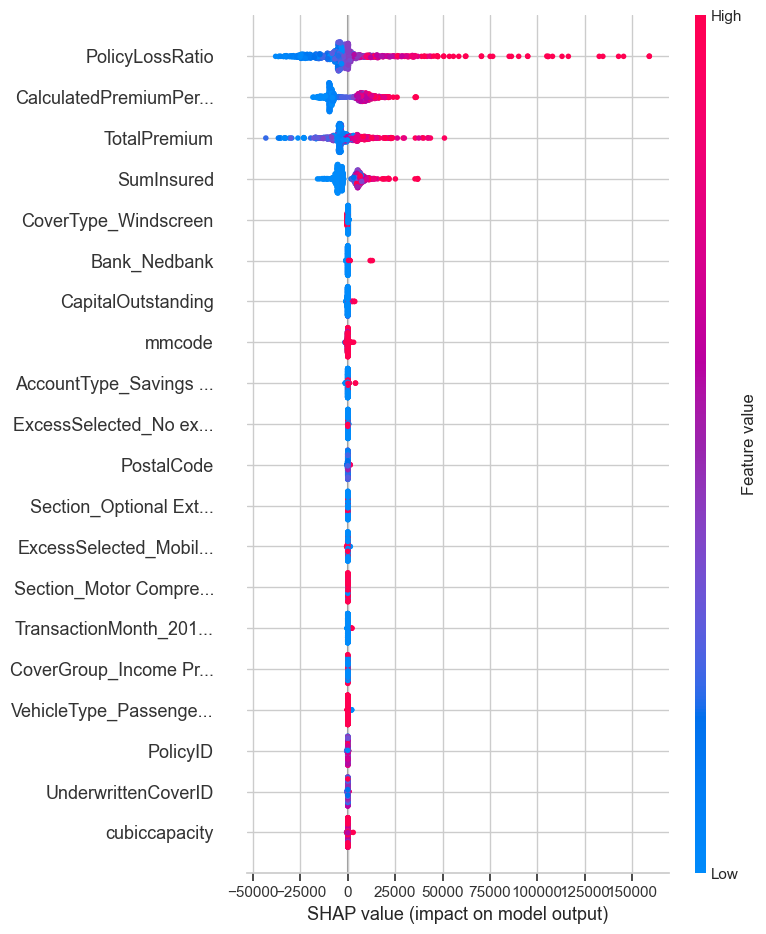

c:\Users\derej\Desktop\Kifya\ML\.venv\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\derej\Desktop\Kifya\ML\.venv\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\derej\Desktop\Kifya\ML\.venv\Lib\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame beh

Intercept 541138.9190513287
Prediction_local [28777.64536555]
Right: 842.743059140214


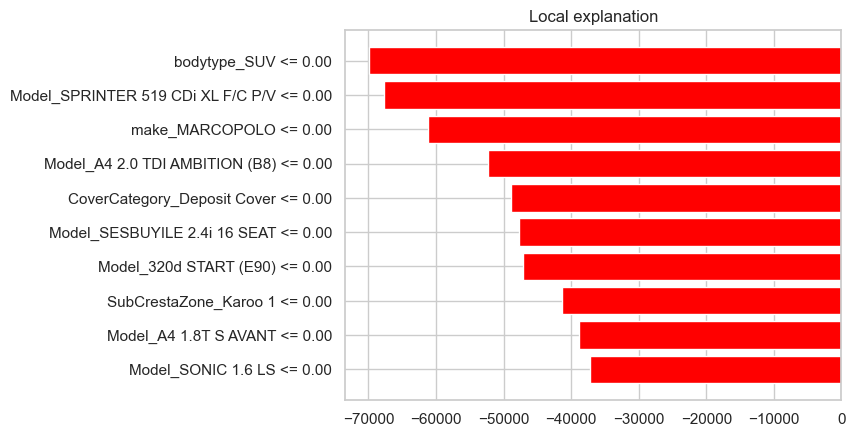

In [23]:
# -----------------------------
# Step 3: Feature Importance (SHAP + LIME)
# -----------------------------

import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import numpy as np

# --- 3a: SHAP Feature Importance (short column names) ---

# Shorten column names for plots
X_test_short = X_test.copy()
short_names = {col: (col[:20] + '...' if len(col) > 20 else col) for col in X_test.columns}
X_test_short.rename(columns=short_names, inplace=True)

# Example: using RandomForest model
model = models['RandomForest']

# SHAP explainer
explainer_shap = shap.TreeExplainer(model)
shap_values = explainer_shap.shap_values(X_test)

# Global feature importance (bar plot)
shap.summary_plot(shap_values, X_test_short, plot_type="bar")

# Detailed SHAP summary plot (beeswarm)
shap.summary_plot(shap_values, X_test_short)


# --- 3b: LIME Feature Importance ---

# LIME explainer
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    mode='regression',  # 'classification' for classification tasks
    verbose=True,
    random_state=42
)

# Explain a single instance (e.g., first test sample)
i = 0
exp_lime = explainer_lime.explain_instance(
    data_row=X_test.iloc[i],
    predict_fn=model.predict,
    num_features=10  # top features to show
)

# Render explanation using matplotlib (works in all environments)
fig = exp_lime.as_pyplot_figure()
plt.show()


In [24]:
# -----------------------------
# Step 4: Hyperparameter Tuning
# -----------------------------

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

# Dictionary to store tuned models
tuned_models = {}

# -----------------------------
# 4a: RandomForest Regressor
# -----------------------------
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_grid = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=rf_params,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
rf_grid.fit(X_train, y_train)
tuned_models['RandomForest'] = rf_grid.best_estimator_
print("RandomForest best params:", rf_grid.best_params_)

# -----------------------------
# 4b: DecisionTree Regressor
# -----------------------------
dt_params = {
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

dt_grid = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_grid=dt_params,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
dt_grid.fit(X_train, y_train)
tuned_models['DecisionTree'] = dt_grid.best_estimator_
print("DecisionTree best params:", dt_grid.best_params_)

# -----------------------------
# 4c: XGBoost Regressor
# -----------------------------
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

xgb_grid = GridSearchCV(
    estimator=xgb.XGBRegressor(random_state=42, objective='reg:squarederror'),
    param_grid=xgb_params,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
xgb_grid.fit(X_train, y_train)
tuned_models['XGBoost'] = xgb_grid.best_estimator_
print("XGBoost best params:", xgb_grid.best_params_)

# -----------------------------
# 4d: Linear Regression (no hyperparameters, just add to dictionary)
# -----------------------------
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
tuned_models['LinearRegression'] = lr_model
print("LinearRegression trained (no hyperparameters to tune)")

# -----------------------------
# 4e: Evaluate tuned models on test set
# -----------------------------
results = []
for name, model in tuned_models.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    results.append({'Model': name, 'RMSE': rmse, 'R2': r2})

results_df = pd.DataFrame(results).sort_values(by='R2', ascending=False)
print(results_df)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
RandomForest best params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Fitting 3 folds for each of 12 candidates, totalling 36 fits
DecisionTree best params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5}
Fitting 3 folds for each of 18 candidates, totalling 54 fits
XGBoost best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
LinearRegression trained (no hyperparameters to tune)
              Model          RMSE        R2
0      RandomForest   8493.081158  0.948328
2           XGBoost  10860.232127  0.915510
1      DecisionTree  11697.135111  0.901987
3  LinearRegression  30551.547541  0.331361


C:\Users\derej\AppData\Local\Temp\ipykernel_270884\782837968.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='RMSE', y='Model', data=results_df, palette='viridis')


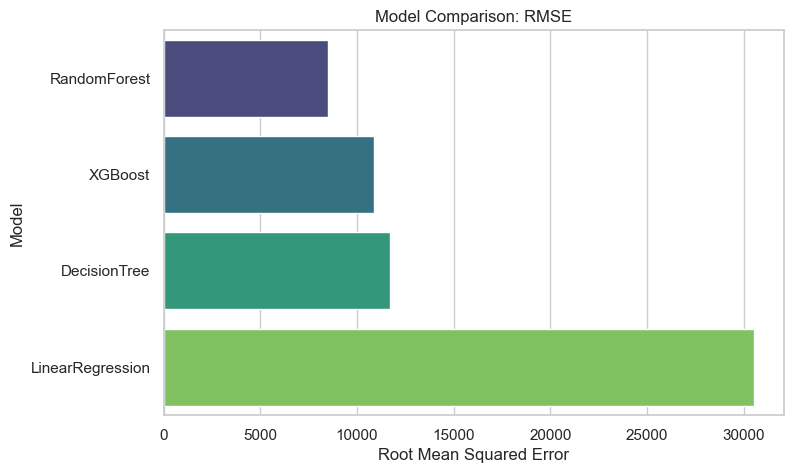

C:\Users\derej\AppData\Local\Temp\ipykernel_270884\782837968.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='R2', y='Model', data=results_df, palette='magma')


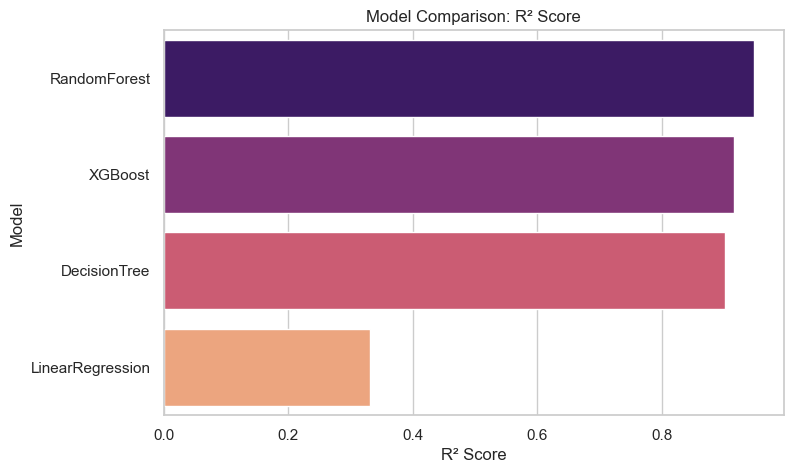

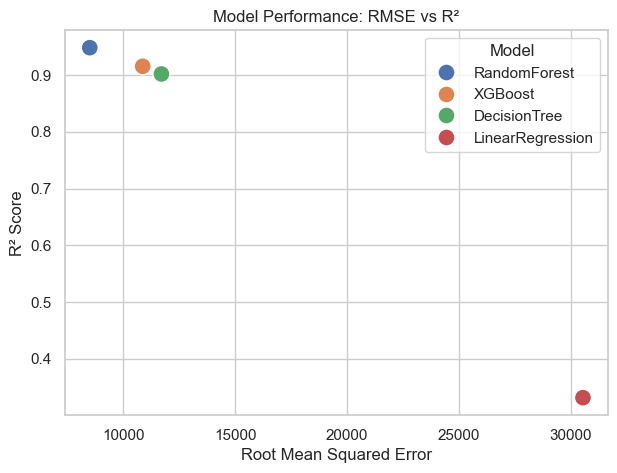

Performance Summary:


,Model,RMSE,R2
0,RandomForest,8493.081158,0.948328
2,XGBoost,10860.232127,0.915510
1,DecisionTree,11697.135111,0.901987
3,LinearRegression,30551.547541,0.331361


In [25]:
# -----------------------------
# Step 5: Model Performance Comparison
# -----------------------------
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Bar plot for RMSE
plt.figure(figsize=(8, 5))
sns.barplot(x='RMSE', y='Model', data=results_df, palette='viridis')
plt.title('Model Comparison: RMSE')
plt.xlabel('Root Mean Squared Error')
plt.ylabel('Model')
plt.show()

# Bar plot for R²
plt.figure(figsize=(8, 5))
sns.barplot(x='R2', y='Model', data=results_df, palette='magma')
plt.title('Model Comparison: R² Score')
plt.xlabel('R² Score')
plt.ylabel('Model')
plt.show()

# Optional: Scatter plot RMSE vs R²
plt.figure(figsize=(7, 5))
sns.scatterplot(x='RMSE', y='R2', hue='Model', data=results_df, s=150)
plt.title('Model Performance: RMSE vs R²')
plt.xlabel('Root Mean Squared Error')
plt.ylabel('R² Score')
plt.legend(title='Model')
plt.show()

# Display results table
print("Performance Summary:")
display(results_df)
